In [2]:
import argparse
from adbtools_win import Adbtools
import numpy as np
from PIL import Image
import time
from imgtools import are_images_similar_mse , box2center, img_crop

#from PokemonPosition import PokemonPosition ,pokemon素材
import hashlib
import os
from io import BytesIO

import csv
from collections import defaultdict

import xml.etree.ElementTree as ET
from datetime import datetime
import re

In [3]:
mac1 = "1ab4919e"
mac2 = "2d5757ea" 
mac3 = "18608847" 
mac4 = "58517171"


In [4]:
host = "localhost"  # 替换为你的设备IP
port = 16449  # ADB默认端口
adb_path = r'D:\安卓工具\platform-tools-latest-windows\platform-tools\adb.exe ' # ADB路径
mac = mac1  # 从命令行传入的MAC地址
adb_screenshot = Adbtools(adb_path, host, port, mac )
img=adb_screenshot.adb_screencap_raw()
save_dir="F:/视频截图/"
file_path = os.path.join(save_dir, f"{time.time()}.png")
img.save(file_path)
#Adbtools(adb_path, host, port, mac ).adb_swipe_raw(500,1000,500,100, 300)

设备分辨率: 1080x1920


1080 1920 1


In [5]:
#img
Adbtools(adb_path, host, port, mac ).get_uixml_via_stdout()

设备分辨率: 1080x1920


'<?xml version=\'1.0\' encoding=\'UTF-8\' standalone=\'yes\' ?><hierarchy rotation="0"><node index="0" text="" resource-id="" class="android.widget.FrameLayout" package="tv.danmaku.bili" content-desc="" checkable="false" checked="false" clickable="false" enabled="true" focusable="false" focused="false" scrollable="false" long-clickable="false" password="false" selected="false" bounds="[0,0][1080,1920]"><node index="0" text="" resource-id="" class="android.widget.LinearLayout" package="tv.danmaku.bili" content-desc="" checkable="false" checked="false" clickable="false" enabled="true" focusable="false" focused="false" scrollable="false" long-clickable="false" password="false" selected="false" bounds="[0,0][1080,1920]"><node index="0" text="" resource-id="" class="android.widget.FrameLayout" package="tv.danmaku.bili" content-desc="" checkable="false" checked="false" clickable="false" enabled="true" focusable="false" focused="false" scrollable="false" long-clickable="false" password="false

In [6]:
root = ET.fromstring(Adbtools(adb_path, host, port, mac ).get_uixml_via_stdout())

设备分辨率: 1080x1920


In [7]:
def find_video_covers(xml_str):
    def parse_bounds(bounds_str):
        nums = list(map(int, re.findall(r'\d+', bounds_str)))
        return tuple(nums)  # (x1, y1, x2, y2)

    root = ET.fromstring(xml_str)
    boxes = []

    for node in root.iter('node'):
        if node.attrib.get('class') == 'android.widget.ImageView':
            if node.attrib.get('resource-id') == 'tv.danmaku.bili:id/cover':
                bounds = node.attrib.get('bounds')
                if bounds:
                    box = parse_bounds(bounds)
                    boxes.append(box)
    return boxes


In [8]:
boxes = find_video_covers(Adbtools(adb_path, host, port, mac ).get_uixml_via_stdout())
crops = []  # 用于保存裁剪后的图像对象
for box in boxes:
    crop = img_crop(img, box)
    crops.append(crop)

设备分辨率: 1080x1920


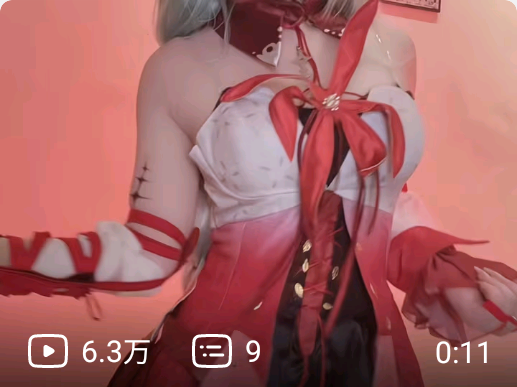

In [44]:
crops[0]

In [45]:
import base64
from io import BytesIO

def image_to_base64(img, format='PNG'):
    buffered = BytesIO()
    img.save(buffered, format=format)
    img_bytes = buffered.getvalue()
    base64_str = base64.b64encode(img_bytes).decode('utf-8')
    return base64_str


In [11]:
#os.getenv('DASHSCOPE_API_KEY')

{
  "擦边等级": 7,
  "tags": [
    "暴露服装",
    "性感姿态",
    "舞台背景",
    "手部动作",
    "时尚装扮"
  ]
}



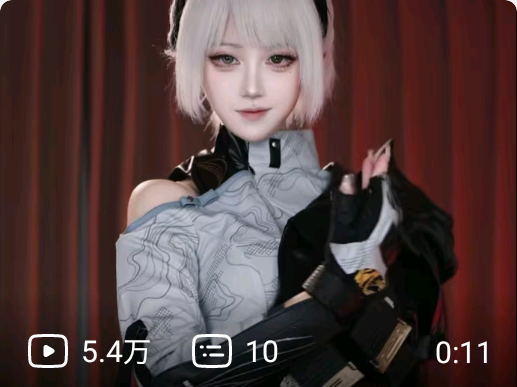

In [53]:
from openai import OpenAI
import os
import base64




# 将xxxx/eagle.png替换为你本地图像的绝对路径
base64_image = image_to_base64(crops[4], format='PNG')

client = OpenAI(
    # 若没有配置环境变量，请用百炼API Key将下行替换为：api_key="sk-xxx"
    api_key=os.getenv('DASHSCOPE_API_KEY'),
    base_url="https://dashscope.aliyuncs.com/compatible-mode/v1",
)
completion = client.chat.completions.create(
    model="qwen-vl-max-latest", # 此处以qwen-vl-max-latest为例，可按需更换模型名称。模型列表：https://help.aliyun.com/zh/model-studio/models
    messages=[
    	{
    	    "role": "system",
            "content": [{"type":"text","text": "You are a helpful assistant."}]},
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    # 需要注意，传入Base64，图像格式（即image/{format}）需要与支持的图片列表中的Content Type保持一致。"f"是字符串格式化的方法。
                    # PNG图像：  f"data:image/png;base64,{base64_image}"
                    # JPEG图像： f"data:image/jpeg;base64,{base64_image}"
                    # WEBP图像： f"data:image/webp;base64,{base64_image}"
                    "image_url": {"url": f"data:image/png;base64,{base64_image}"}, 
                },
                {"type": "text", "text": "以标准的json格式输出用于描述图片擦边女主播等级，分为10个等级，为10级为100%确认的擦边女主播，1级为完全不是。的简短tag"},
            ],
        }
    ],
    response_format={"type": "json_object"},
)
print(completion.choices[0].message.content)
crops[4]